<a href="https://colab.research.google.com/github/lasiadhi/Prediction-of-hypoxemia-trend/blob/master/Vent_Event_times.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
#################################################
###### @author: Lasith Adhikari (python 3)  #####
############ Created on Nov 15, 2019 ############
# Code description: 
# Explore Ventilation event table 

In [0]:
# Import libraries
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.path as path
import tensorflow as tf

# Below imports are used to print out pretty pandas dataframes
from IPython.display import display, HTML

# Imports for accessing Datathon data using Google BigQuery.
from google.colab import auth
from google.cloud import bigquery

In [0]:
from google.colab import files
import seaborn as sns
import pickle
import matplotlib.pyplot as plt 

In [0]:
auth.authenticate_user()

In [0]:
# Note that this should be the project for the datathon work,
# not the physionet-data project which is for data hosting.
project_id = 'hst-953-2019'
os.environ['GOOGLE_CLOUD_PROJECT'] = project_id

In [0]:

# Read data from BigQuery into pandas dataframes.
def run_query(query):
  return pd.io.gbq.read_gbq(
      query,
      project_id=project_id,
      dialect='standard')

In [0]:
df_vent_event = run_query("""
select *
from `physionet-data.eicu_crd_derived.ventilation_events` 
"""
)

In [0]:
df_vent_event.head()

,patientunitstayid,event,hrs
0,586256,Trach,0.00
1,941389,Trach,0.00
2,539192,Trach,2.00
3,734549,Trach,2.00
4,637578,Trach,3.75


In [7]:
df_vent_event.shape

(92218, 3)

In [8]:
df_vent_event.patientunitstayid.nunique()

22859

In [0]:
df_vent_event.event.unique()

array(['Trach', 'o2end', 'nivend', 'o2 end', 'niv end', 'o2 start',
       'ICU Admit', 'niv start', 'roomair end', 'mechvent end',
       'ICU Discharge', 'mechvent start'], dtype=object)

In [0]:
df_vent_event_1 = df_vent_event.sort_values(by=['patientunitstayid','hrs']).reset_index(drop=True)

In [0]:
#df_vent_event_1.loc[df_vent_event_1.hrs<0, 'hrs'] = 0

In [10]:
df_vent_event_1.head()

,patientunitstayid,event,hrs
0,534589,ICU Admit,0.000000
1,534589,ICU Discharge,7.100000
2,534590,ICU Admit,0.000000
3,534590,ICU Discharge,22.700000
4,534605,mechvent start,-0.083333


In [11]:
# First try to construct a dictionary of times for a example pid:
df_test = df_vent_event_1[df_vent_event_1.patientunitstayid==539163]
df_test

,patientunitstayid,event,hrs
483,539163,o2 start,-0.483333
484,539163,ICU Admit,0.000000
485,539163,o2end,2.516667
486,539163,mechvent start,2.516667
487,539163,niv start,25.350000
488,539163,mechvent end,25.350000
489,539163,niv end,51.350000
490,539163,o2 start,51.350000
491,539163,niv start,57.216667
492,539163,niv end,76.350000


In [0]:
event_dict = {}
for pid in df_test.patientunitstayid.unique():
  df = df_test[df_test.patientunitstayid==pid]  # read the data for given id

  # read admit time(s) as a list:
  event_dict['ICU Admit'] = list(df[df.event=='ICU Admit'].hrs.values)

  # read all O2 event start and stop times as a list of tuples
  df_type = df.loc[(df.event=='o2 start') | (df.event=='o2 end')| (df.event=='o2end'),['event','hrs']]
  df_type = pd.concat([df_type, df_type.shift(-1)], axis=1)
  df_type.columns = ['event_s', 'hrs_s', 'event_e', 'hrs_e']
  df_type = df_type[df_type.event_s=='o2 start']
  df_type.loc[df_type.event_e=='o2 start', 'hrs_e'] = np.NaN
  event_dict['O2'] = list(zip(round(df_type.hrs_s,3), round(df_type.hrs_e,3)))


  # read all niv event start and stop times as a list of tuples
  df_type = df.loc[(df.event=='niv start') | (df.event=='niv end')| (df.event=='nivend'),['event','hrs']]
  df_type = pd.concat([df_type, df_type.shift(-1)], axis=1)
  df_type.columns = ['event_s', 'hrs_s', 'event_e', 'hrs_e']
  df_type = df_type[df_type.event_s=='niv start']
  df_type.loc[df_type.event_e=='niv start', 'hrs_e'] = np.NaN
  event_dict['NIV'] = list(zip(round(df_type.hrs_s,3), round(df_type.hrs_e,3)))


  # read all iv event start and stop times as a list of tuples
  df_type = df.loc[(df.event=='mechvent start') | (df.event=='mechvent end'),['event','hrs']]
  df_type = pd.concat([df_type, df_type.shift(-1)], axis=1)
  df_type.columns = ['event_s', 'hrs_s', 'event_e', 'hrs_e']
  df_type = df_type[df_type.event_s=='mechvent start']
  df_type.loc[df_type.event_e=='mechvent start', 'hrs_e'] = np.NaN
  event_dict['IV'] = list(zip(round(df_type.hrs_s,3), round(df_type.hrs_e,3)))

  # read discharge time(s) as a list:
  event_dict['ICU Discharge'] = list(df[df.event=='ICU Discharge'].hrs.values)


In [13]:

event_dict

{'ICU Admit': [0.0],
 'ICU Discharge': [313.68333333333334],
 'IV': [(2.517, 25.35), (127.35, 215.6), (299.35, nan)],
 'NIV': [(25.35, 51.35), (57.217, 76.35), (126.883, 127.35)],
 'O2': [(-0.483, 2.517),
  (51.35, nan),
  (76.35, nan),
  (215.6, 276.35),
  (280.35, 299.35)]}

In [0]:
type(event_dict['O2'][1][1])


float

In [14]:
df_vent_event_1.patientunitstayid.nunique()

22859

Let's apply this for the whole dataframe

In [15]:
event_icu_dict = {}
i = 1
for pid in df_vent_event_1.patientunitstayid.unique():
  print(i)
  event_dict = {}
  df = df_vent_event_1[df_vent_event_1.patientunitstayid==pid]  # read the data for given id

  # read admit time(s) as a list:
  event_dict['ICU Admit'] = list(df[df.event=='ICU Admit'].hrs.values)

  # read all O2 event start and stop times as a list of tuples
  df_type = df.loc[(df.event=='o2 start') | (df.event=='o2 end')| (df.event=='o2end'),['event','hrs']]
  df_type = pd.concat([df_type, df_type.shift(-1)], axis=1)
  df_type.columns = ['event_s', 'hrs_s', 'event_e', 'hrs_e']
  df_type = df_type[df_type.event_s=='o2 start']
  df_type.loc[df_type.event_e=='o2 start', 'hrs_e'] = np.NaN
  event_dict['O2'] = list(zip(round(df_type.hrs_s,3), round(df_type.hrs_e,3)))


  # read all niv event start and stop times as a list of tuples
  df_type = df.loc[(df.event=='niv start') | (df.event=='niv end')| (df.event=='nivend'),['event','hrs']]
  df_type = pd.concat([df_type, df_type.shift(-1)], axis=1)
  df_type.columns = ['event_s', 'hrs_s', 'event_e', 'hrs_e']
  df_type = df_type[df_type.event_s=='niv start']
  df_type.loc[df_type.event_e=='niv start', 'hrs_e'] = np.NaN
  event_dict['NIV'] = list(zip(round(df_type.hrs_s,3), round(df_type.hrs_e,3)))


  # read all iv event start and stop times as a list of tuples
  df_type = df.loc[(df.event=='mechvent start') | (df.event=='mechvent end'),['event','hrs']]
  df_type = pd.concat([df_type, df_type.shift(-1)], axis=1)
  df_type.columns = ['event_s', 'hrs_s', 'event_e', 'hrs_e']
  df_type = df_type[df_type.event_s=='mechvent start']
  df_type.loc[df_type.event_e=='mechvent start', 'hrs_e'] = np.NaN
  event_dict['IV'] = list(zip(round(df_type.hrs_s,3), round(df_type.hrs_e,3)))

  # read discharge time(s) as a list:
  event_dict['ICU Discharge'] = list(df[df.event=='ICU Discharge'].hrs.values)

  event_icu_dict[pid] =  event_dict
  i+=1


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


In [16]:
event_icu_dict

{534589: {'ICU Admit': [0.0],
  'ICU Discharge': [7.1],
  'IV': [],
  'NIV': [],
  'O2': []},
 534590: {'ICU Admit': [0.0],
  'ICU Discharge': [22.7],
  'IV': [],
  'NIV': [],
  'O2': []},
 534605: {'ICU Admit': [0.0],
  'ICU Discharge': [46.75],
  'IV': [(-0.083, 14.633)],
  'NIV': [],
  'O2': [(14.633, nan)]},
 534621: {'ICU Admit': [0.0],
  'ICU Discharge': [23.316666666666666],
  'IV': [(-0.317, 4.35)],
  'NIV': [],
  'O2': [(4.35, nan)]},
 534622: {'ICU Admit': [0.0],
  'ICU Discharge': [28.55],
  'IV': [],
  'NIV': [],
  'O2': [(0.283, 16.283), (17.283, nan)]},
 534637: {'ICU Admit': [0.0],
  'ICU Discharge': [18.916666666666668],
  'IV': [],
  'NIV': [],
  'O2': []},
 534930: {'ICU Admit': [0.0],
  'ICU Discharge': [45.35],
  'IV': [],
  'NIV': [(0.5, nan)],
  'O2': [(0.0, nan)]},
 534942: {'ICU Admit': [0.0],
  'ICU Discharge': [26.083333333333332],
  'IV': [],
  'NIV': [],
  'O2': [(-0.667, nan)]},
 534967: {'ICU Admit': [0.0],
  'ICU Discharge': [52.31666666666667],
  'IV': [

In [19]:
len(event_icu_dict.keys())

22859

In [0]:
f = open("MVdict_from_ventEventtbl_with_DC.pkl","wb")
pickle.dump(event_icu_dict,f)
f.close()
#files.download('MVdict_from_ventEventtbl_with_DC.pkl')

Read filterd dict with first ICU episod (from Crystal)

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
first_icuid_dict = pickle.load(open("/content/drive/My Drive/Colab Notebooks/data/final_df_ver1", "rb" ) )


In [0]:
#Examples;
first_icuid_dict[3343558]

{'ICU Admit': [0.0],
 'ICU Discharge': [176.11666666666667],
 'IV': [(0.0, 42.683)],
 'NIV': [(42.683, 83.917)],
 'O2': [(83.917, nan)]}

In [0]:
len(first_icuid_dict.keys())

17053

In [7]:
# count Ids without IV:
count_iv_empty = 0
for i in first_icuid_dict.keys():
  iv_list = first_icuid_dict[i]['IV']
  if len(iv_list) == 0:
    count_iv_empty += 1
  elif 
  if np.isnan(iv_start_time):
    count_iv_empty += 1
print(count_iv_empty)

IndexError: ignored

In [0]:
first_icuid_dict

{534589: {'ICU Admit': [0.0],
  'ICU Discharge': [7.1],
  'IV': [],
  'NIV': [],
  'O2': []},
 534605: {'ICU Admit': [0.0],
  'ICU Discharge': [46.75],
  'IV': [(-0.083, 14.633)],
  'NIV': [],
  'O2': [(14.633, nan)]},
 534621: {'ICU Admit': [0.0],
  'ICU Discharge': [23.316666666666666],
  'IV': [(-0.317, 4.35)],
  'NIV': [],
  'O2': [(4.35, nan)]},
 534637: {'ICU Admit': [0.0],
  'ICU Discharge': [18.916666666666668],
  'IV': [],
  'NIV': [],
  'O2': []},
 534930: {'ICU Admit': [0.0],
  'ICU Discharge': [45.35],
  'IV': [],
  'NIV': [(0.5, nan)],
  'O2': [(0.0, nan)]},
 534942: {'ICU Admit': [0.0],
  'ICU Discharge': [26.083333333333332],
  'IV': [],
  'NIV': [],
  'O2': [(-0.667, nan)]},
 534967: {'ICU Admit': [0.0],
  'ICU Discharge': [52.31666666666667],
  'IV': [],
  'NIV': [(0.45, nan)],
  'O2': []},
 534981: {'ICU Admit': [0.0],
  'ICU Discharge': [26.633333333333333],
  'IV': [],
  'NIV': [],
  'O2': []},
 535141: {'ICU Admit': [0.0],
  'ICU Discharge': [3.4833333333333334],
 

1. Compute %ICU stays with atleast one complete start and end time for IV:

In [0]:
complete_count_IV = 0
for i in first_icuid_dict.keys():
  i_list = first_icuid_dict[i]['IV']
  for j in i_list:
    if (~np.isnan(j[0])) & (~np.isnan(j[1])):
      complete_count_IV+=1 
      break
  
print(' Percentage of ICU stays with atleast one complete start and end time for IV:', round(complete_count_IV/len(first_icuid_dict.keys())*100,2), '%')
  

 Percentage of ICU stays with atleast one complete start and end time for IV: 20.66 %


2. Compute %ICU stays with atleast one complete start and end time for NIV:

In [0]:
complete_count_NIV = 0
for i in first_icuid_dict.keys():
  i_list = first_icuid_dict[i]['NIV']
  for j in i_list:
    if (~np.isnan(j[0])) & (~np.isnan(j[1])):
      complete_count_NIV+=1 
      break
  
print(' Percentage of ICU stays with atleast one complete start and end time for NIV:', round(complete_count_NIV/len(first_icuid_dict.keys())*100,2), '%')

 Percentage of ICU stays with atleast one complete start and end time for NIV: 9.77 %


3. Compute %ICU stays with atleast one complete start and end time for O2:

In [0]:
complete_count_O2 = 0
for i in first_icuid_dict.keys():
  i_list = first_icuid_dict[i]['O2']
  for j in i_list:
    if (~np.isnan(j[0])) & (~np.isnan(j[1])):
      complete_count_O2+=1 
      break
  
print(' Percentage of ICU stays with atleast one complete start and end time for O2:', round(complete_count_O2/len(first_icuid_dict.keys())*100,2), '%')

 Percentage of ICU stays with atleast one complete start and end time for O2: 15.34 %


4. Compute %ICU stays with atleast one complete start and end time for any vent type:

In [0]:
complete_count_any = 0
for i in first_icuid_dict.keys():
  i_list_1 = first_icuid_dict[i]['O2']
  i_list_2 = first_icuid_dict[i]['IV']
  i_list_3  = first_icuid_dict[i]['NIV']

  i_list = i_list_1 + i_list_2 + i_list_3
  for j in i_list:
    if (~np.isnan(j[0])) & (~np.isnan(j[1])):
      complete_count_any+=1 
      break
  
print(' Percentage of ICU stays with atleast one complete start and end time for any device:', round(complete_count_any/len(first_icuid_dict.keys())*100,2), '%')

 Percentage of ICU stays with atleast one complete start and end time for any device: 34.92 %


New analayis lncluding negative start times but both negative start and stop

IV: 

In [0]:
complete_count_IV = 0
complte_count_all = 0
for i in first_icuid_dict.keys():
  i_list = first_icuid_dict[i]['IV']
  for j in i_list:
    if (~np.isnan(j[0]) | ~np.isnan(j[1])):
      if (~np.isnan(j[0]) & (j[0]<0)) & (~np.isnan(j[1]) & (j[1]<0)):
        continue
      else:
        complete_count_IV+=1 

  i_list_1 = first_icuid_dict[i]['O2']
  i_list_2 = first_icuid_dict[i]['IV']
  i_list_3  = first_icuid_dict[i]['NIV']
  i_list = i_list_1 + i_list_2 + i_list_3
  for j in i_list:
    if (~np.isnan(j[0])) | (~np.isnan(j[1])):
      if (~np.isnan(j[0]) & (j[0]<0)) & (~np.isnan(j[1]) & (j[1]<0)):
        continue
      else:
        complte_count_all+=1 

print('#episodes with at least one start/end for IV:', complete_count_IV)
print('#episodes with at least one start/end for IV:', complte_count_all)
print('Percentage of episodes with at least one start/end for IV:', round(complete_count_IV/complte_count_all*100,2), '%')
  

#episodes with at least one start/end for IV: 8337
#episodes with at least one start/end for IV: 20213
Percentage of episodes with at least one start/end for IV: 41.25 %


NIV:

In [0]:
complete_count_IV = 0
complte_count_all = 0
for i in first_icuid_dict.keys():
  i_list = first_icuid_dict[i]['NIV']
  for j in i_list:
    if (~np.isnan(j[0]) | ~np.isnan(j[1])):
       if (~np.isnan(j[0]) & (j[0]<0)) & (~np.isnan(j[1]) & (j[1]<0)):
        continue
       else:
        complete_count_IV+=1 

  i_list_1 = first_icuid_dict[i]['O2']
  i_list_2 = first_icuid_dict[i]['IV']
  i_list_3  = first_icuid_dict[i]['NIV']
  i_list = i_list_1 + i_list_2 + i_list_3
  for j in i_list:
    if (~np.isnan(j[0])) | (~np.isnan(j[1])):
      if (~np.isnan(j[0]) & (j[0]<0)) & (~np.isnan(j[1]) & (j[1]<0)):
        continue
      else:
        complte_count_all+=1 

print('#episodes with at least one start/end for NIV:', complete_count_IV)
print('#episodes with at least one start/end for NIV:', complte_count_all)
print('Percentage of episodes with at least one start/end for NIV:', round(complete_count_IV/complte_count_all*100,2), '%')
  

#episodes with at least one start/end for NIV: 3220
#episodes with at least one start/end for NIV: 20213
Percentage of episodes with at least one start/end for NIV: 15.93 %


O2

In [0]:
complete_count_IV = 0
complte_count_all = 0
for i in first_icuid_dict.keys():
  i_list = first_icuid_dict[i]['O2']
  for j in i_list:
    if (~np.isnan(j[0]) | ~np.isnan(j[1])):
       if (~np.isnan(j[0]) & (j[0]<0)) & (~np.isnan(j[1]) & (j[1]<0)):
        continue
       else:
        complete_count_IV+=1 

  i_list_1 = first_icuid_dict[i]['O2']
  i_list_2 = first_icuid_dict[i]['IV']
  i_list_3  = first_icuid_dict[i]['NIV']
  i_list = i_list_1 + i_list_2 + i_list_3
  for j in i_list:
    if (~np.isnan(j[0])) | (~np.isnan(j[1])):
      if (~np.isnan(j[0]) & (j[0]<0)) & (~np.isnan(j[1]) & (j[1]<0)):
        continue
      else:
        complte_count_all+=1

print('#episodes with at least one start/end for O2:', complete_count_IV)
print('#episodes with at least one start/end for O2:', complte_count_all)
print('Percentage of episodes with at least one start/end for O2:', round(complete_count_IV/complte_count_all*100,2), '%')
  

#episodes with at least one start/end for O2: 8656
#episodes with at least one start/end for O2: 20213
Percentage of episodes with at least one start/end for O2: 42.82 %


# Plot 

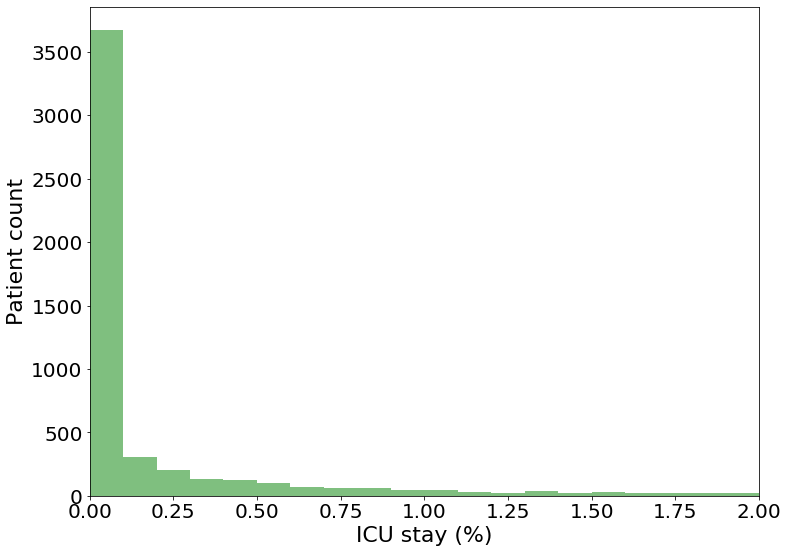

count    6725.000000
mean        5.765556
std        15.062797
min         0.000000
25%         0.000000
50%         0.038783
75%         1.962323
max        99.959163
dtype: float64

In [0]:
## IV start times:
complete_list = []
for i in first_icuid_dict.keys():
  admit_offset = first_icuid_dict[i]['ICU Admit'][0]
  discharge_offset = first_icuid_dict[i]['ICU Discharge'][0]

  LOS_i = discharge_offset - admit_offset
  #LOS_i = min(7*24,LOS_i) # set max LOS to 7
  if (LOS_i>=12):   # consider patients with LOS>12hrs
    i_list = first_icuid_dict[i]['IV']
    for j in i_list:
      if (~np.isnan(j[0])) | (~np.isnan(j[1])): # one side time has to be available 
        if (np.isnan(j[0])) | (j[0]<=0): 
          #continue 
          complete_list.append(0)
        elif j[0]<LOS_i:
          complete_list.append(j[0]/LOS_i*100)
        break
  
complete_start_series_IV = pd.Series(complete_list)

plt.gcf().set_size_inches(12, 9)
n, bins, patches = plt.hist(complete_start_series_IV, 1000, density=False, facecolor='g', alpha=0.5)
plt.xlabel('ICU stay (%)', fontsize=22)
plt.ylabel('Patient count', fontsize=22)
plt.xticks(fontsize=20, rotation=0)
plt.yticks(fontsize=20, rotation=0)
#plt.title('Distribution of LOS', fontsize=20)
plt.xlim([0,2])
#plt.grid(True)
plt.show()

complete_start_series_IV.describe()

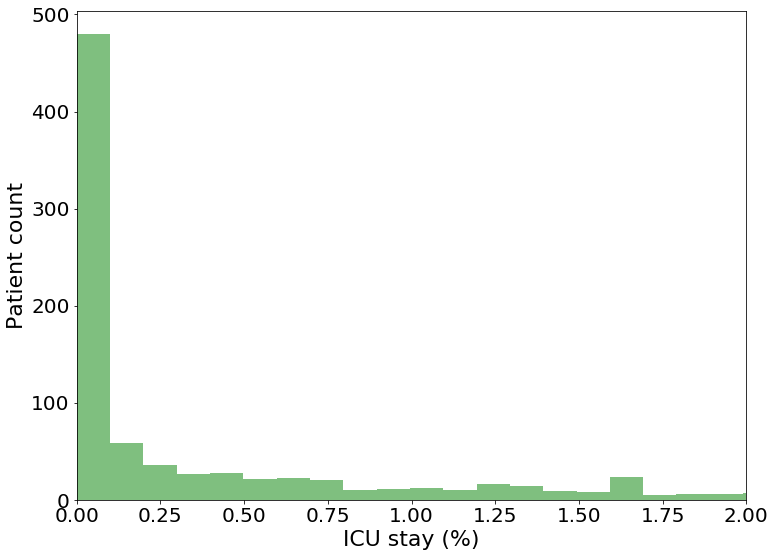

count    2332.000000
mean       21.414853
std        25.882334
min         0.000000
25%         0.319962
50%         9.147692
75%        36.794618
max        99.526907
dtype: float64

In [0]:
## 
## NIV start times:
complete_list = []
for i in first_icuid_dict.keys():
  admit_offset = first_icuid_dict[i]['ICU Admit'][0]
  discharge_offset = first_icuid_dict[i]['ICU Discharge'][0]

  LOS_i = discharge_offset - admit_offset
  #LOS_i = min(7*24,LOS_i) # set max LOS to 7
  if (LOS_i>=12):   # consider patients with LOS>12hrs
    i_list = first_icuid_dict[i]['NIV']
    for j in i_list:
      if (~np.isnan(j[0])) | (~np.isnan(j[1])):
        if (np.isnan(j[0])) | (j[0]<=0):
          #continue 
          complete_list.append(0)
        elif j[0]<LOS_i:
          complete_list.append(j[0]/LOS_i*100)
        break
  
complete_start_series_NIV = pd.Series(complete_list)

plt.gcf().set_size_inches(12, 9)
n, bins, patches = plt.hist(complete_start_series_NIV, 1000, density=False, facecolor='g', alpha=0.5)
plt.xlabel('ICU stay (%)', fontsize=22)
plt.ylabel('Patient count', fontsize=22)
plt.xticks(fontsize=20, rotation=0)
plt.yticks(fontsize=20, rotation=0)
#plt.title('Distribution of LOS', fontsize=20)
plt.xlim([0,2])
#plt.grid(True)
plt.show()

complete_start_series_NIV.describe()

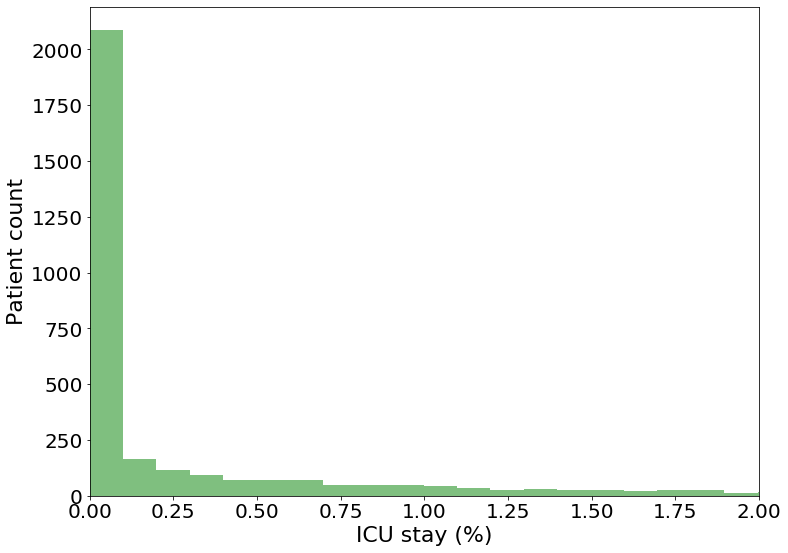

count    6104.000000
mean       16.892629
std        24.962358
min         0.000000
25%         0.000000
50%         1.811750
75%        27.913873
max        99.782751
dtype: float64

In [0]:
## 
## O2 start times:
complete_list = []
for i in first_icuid_dict.keys():
  admit_offset = first_icuid_dict[i]['ICU Admit'][0]
  discharge_offset = first_icuid_dict[i]['ICU Discharge'][0]

  LOS_i = discharge_offset - admit_offset
  #LOS_i = min(7*24,LOS_i) # set max LOS to 7
  if (LOS_i>=12):   # consider patients with LOS>12hrs
    i_list = first_icuid_dict[i]['O2']
    for j in i_list:
      if (~np.isnan(j[0])) | (~np.isnan(j[1])):
        if (np.isnan(j[0])) | (j[0]<=0):
          #continue 
          complete_list.append(0)
        elif j[0]<LOS_i:
          complete_list.append(j[0]/LOS_i*100)
        break
  
complete_start_series_o2 = pd.Series(complete_list)

plt.gcf().set_size_inches(12, 9)
n, bins, patches = plt.hist(complete_start_series_o2, 1000, density=False, facecolor='g', alpha=0.5)
plt.xlabel('ICU stay (%)', fontsize=22)
plt.ylabel('Patient count', fontsize=22)
plt.xticks(fontsize=20, rotation=0)
plt.yticks(fontsize=20, rotation=0)
#plt.title('Distribution of LOS', fontsize=20)
plt.xlim([0,2])
#plt.grid(True)
plt.show()

complete_start_series_o2.describe()

In [0]:
# Combine all three start time distribution plot to one density plot:
# Pr. density plot function:
def density_plot_any(cols, locations, colors, xlab):
    
    loc_col = zip(locations,colors)
    j = 0

    # Iterate through the locations
    for i in loc_col:
        #subset = df_plot[df_plot['outcome']==i[0]]
    # Draw the density plot
        sns.distplot(cols[j], hist=False, kde=True, \
                 bins=200, color = i[1], \
                 hist_kws={'edgecolor':'black'},\
                 kde_kws={'linewidth': 1, "bw":2}, label = i[0], norm_hist=True)
        j+=1
    # Plot formatting
    plt.legend(prop={'size': 16})
    plt.gcf().set_size_inches(15, 9)
    #plt.title('Density Plot for ...', fontsize=20)
    plt.xlabel(xlab, fontsize=25)
    plt.ylabel('Probability density', fontsize=25)
    plt.xlim([0,30])
    plt.axvline(x=0.1, color='red', ymin=0, ymax=0.94, linestyle = '--')
    plt.axvline(x=9.14, color='green', ymin=0, ymax=0.1 , linestyle = '--')
    plt.axvline(x=1.8, color='blue', ymin=0, ymax=0.53 , linestyle = '--')
    #plt.rcParams['xtick.labelsize']=8
    #plt.rcParams['ytick.labelsize']=8
    plt.rc('xtick',labelsize=15)
    plt.rc('ytick',labelsize=15)
    plt.show()

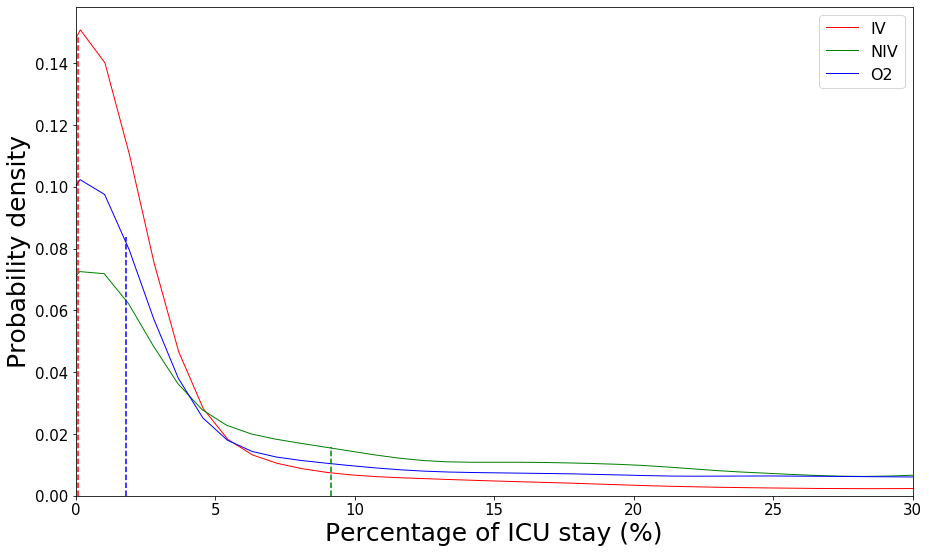

In [0]:
density_plot_any([complete_start_series_IV,complete_start_series_NIV,complete_start_series_o2],\
                 ['IV','NIV','O2'], ['r','g','b'], 'Percentage of ICU stay (%)')


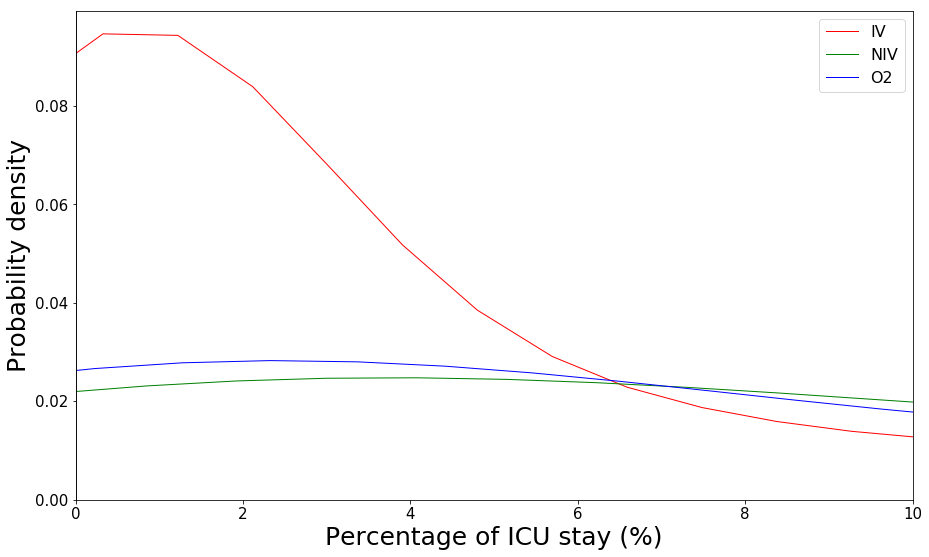

In [0]:
# Without pre-starts (negative|missing start time) before the ICU admission:
density_plot_any([complete_start_series_IV,complete_start_series_NIV,complete_start_series_o2],\
                 ['IV','NIV','O2'], ['r','g','b'], 'Percentage of ICU stay (%)')

**LOS distibution**
Asumption: 12h<=LOS<=7days

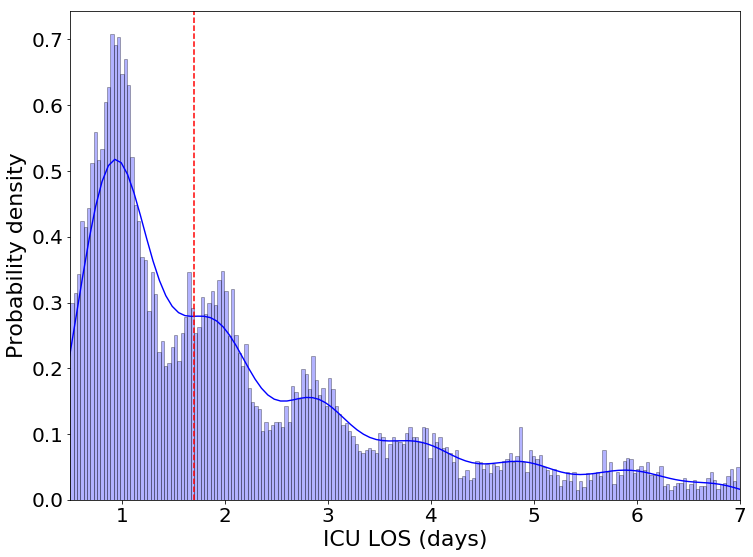

count    12988.000000
mean         2.171029
std          1.525964
min          0.500000
25%          0.986806
50%          1.693403
75%          2.909722
max          6.998611
dtype: float64

In [0]:
complete_list = []
for i in first_icuid_dict.keys():
  admit_offset = first_icuid_dict[i]['ICU Admit'][0]
  discharge_offset = first_icuid_dict[i]['ICU Discharge'][0]

  LOS_i = discharge_offset - admit_offset
  #LOS_i = min(7*24,LOS_i) # set max LOS to 7
  if (LOS_i>=12) & (LOS_i<=7*24) :   # consider patients with LOS>12hrs
    complete_list.append(LOS_i/24.0)
  
complete_start_series = pd.Series(complete_list)
#complete_start_series = complete_start_series[complete_start_series<100.0]

plt.gcf().set_size_inches(12, 9)
#n, bins, patches = plt.hist(complete_start_series, 200, density=False, facecolor='b', alpha=0.5)
sns.distplot(complete_start_series, hist=True, kde=True, \
                 bins=200, color = 'b', \
                 hist_kws={'edgecolor':'black', "alpha": 0.3,},\
                 kde_kws={'linewidth': 1.4}, label = 'ICU LOS', norm_hist=True)
plt.xlabel('ICU LOS (days)', fontsize=22)
plt.ylabel('Probability density', fontsize=22)
plt.xticks(fontsize=20, rotation=0)
plt.yticks(fontsize=20, rotation=0)
plt.axvline(x=1.7, color='red', linestyle = '--')
#plt.title('Distribution of LOS', fontsize=20)
plt.xlim([0.5,7])
#plt.grid(True)
plt.show()

complete_start_series.describe()


In [0]:
complete_start_series.count()/17053*100

76.16255204362868

In [0]:
sum(complete_start_series<12)/17053*100

13.059285756171935

In [0]:
sum(complete_start_series>(7*24))/17053*100

10.778162200199379

In [0]:
complete_list = []
for i in first_icuid_dict.keys():
  #admit_offset = first_icuid_dict[i]['ICU Admit'][0]
  discharge_offset = first_icuid_dict[i]['ICU Discharge'][0]

  complete_list.append(discharge_offset)
  
complete_start_series = pd.Series(complete_list)

In [0]:
complete_start_series.describe()

count    17053.000000
mean        76.448390
std        116.408979
min          0.000000
25%         20.416667
50%         39.516667
75%         82.750000
max       2389.100000
dtype: float64

In [0]:
sum(complete_start_series>(7*24))

1838

**Plot start times vs patient count for each vent type**

1. For first IV start time:

In [0]:
complete_start_list = []
for i in first_icuid_dict.keys():
  i_list = first_icuid_dict[i]['IV']
  admit_offset = first_icuid_dict[i]['ICU Admit'][0]
  discharge_offset = first_icuid_dict[i]['ICU Discharge'][0]
  for j in i_list:
    if (~np.isnan(j[0])) & (discharge_offset>admit_offset):
      start_offset = j[0]
      # normalize start time offset
      norm_start = round(start_offset/(discharge_offset-admit_offset)*100, 3) 
      complete_start_list.append(norm_start)
      break
complete_start_series = pd.Series(complete_start_list)
complete_start_series = complete_start_series[complete_start_series<100.0]

In [0]:
complete_start_series.describe()

count    7081.000000
mean        5.950841
std        15.423131
min         0.000000
25%         0.000000
50%         0.034000
75%         2.102000
max        99.959000
dtype: float64

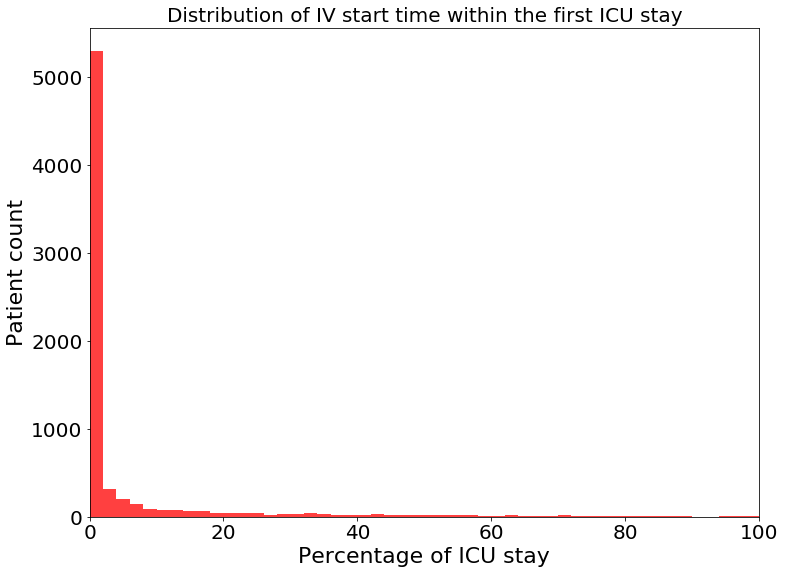

In [0]:
plt.gcf().set_size_inches(12, 9)
n, bins, patches = plt.hist(complete_start_series, 50, density=False, facecolor='r', alpha=0.75)
plt.xlabel('Percentage of ICU stay', fontsize=22)
plt.ylabel('Patient count', fontsize=22)
plt.xticks(fontsize=20, rotation=0)
plt.yticks(fontsize=20, rotation=0)
plt.title('Distribution of IV start time within the first ICU stay', fontsize=20)
plt.xlim([0,100])
#plt.grid(True)
plt.show()

In [0]:
# normalize first IV event using LOS:


In [0]:
complete_list = []
for i in first_icuid_dict.keys():
  admit_offset = first_icuid_dict[i]['ICU Admit'][0]
  discharge_offset = first_icuid_dict[i]['ICU Discharge'][0]

  LOS_i = discharge_offset - admit_offset
  #LOS_i = min(7*24,LOS_i) # set max LOS to 7
  if (LOS_i>=12):   # consider patients with LOS>12hrs
    i_list = first_icuid_dict[i]['IV']
    for j in i_list:
      if (~np.isnan(j[0])) | (~np.isnan(j[1])): # one side time has to be available 
        if (np.isnan(j[0])) | (j[0]<=0): 
          #continue 
          complete_list.append(0)
        elif j[0]<LOS_i:
          complete_list.append(j[0]/LOS_i*100)
        break
  
complete_start_series_IV = pd.Series(complete_list)


In [0]:
complete_start_series_IV.describe()


count    6725.000000
mean        5.765556
std        15.062797
min         0.000000
25%         0.000000
50%         0.038783
75%         1.962323
max        99.959163
dtype: float64

In [0]:
f = open("MV_normalized_times.pkl","wb")
pickle.dump(complete_start_series_IV,f)
f.close()
#files.download('MV_normalized_times.pkl')

# Read PF ratio data..

In [0]:
def density_plot_any_2(cols, locations, colors, xlab):
    
    loc_col = zip(locations,colors)
    j = 0

    # Iterate through the locations
    for i in loc_col:
        #subset = df_plot[df_plot['outcome']==i[0]]
    # Draw the density plot
        sns.distplot(cols[j], hist=False, kde=True, \
                 bins=50, color = i[1], \
                 hist_kws={'edgecolor':'black'},\
                 kde_kws={'linewidth': 1,"bw":1.5}, label = i[0], norm_hist=True)
        j+=1
    # Plot formatting
    plt.legend(prop={'size': 20})
    plt.gcf().set_size_inches(15, 9)
    #plt.title('Density Plot for ...', fontsize=20)
    plt.xlabel(xlab, fontsize=25)
    plt.ylabel('Probability density', fontsize=25)
    plt.xlim([0,30])
    plt.axvline(x=0.1, color='red', ymin=0, ymax=0.94, linestyle = '--')
    plt.axvline(x=8.4, color='blue', ymin=0, ymax=0.11, linestyle = '--')
    #plt.axvline(x=1.8, color='blue', ymin=0, ymax=0.92 , linestyle = '--')
    #plt.rcParams['xtick.labelsize']=8
    #plt.rcParams['ytick.labelsize']=8
    plt.rc('xtick',labelsize=20)
    plt.rc('ytick',labelsize=20)
    plt.show()

In [0]:


both_p_f = pickle.load(open("/content/drive/My Drive/Colab Notebooks/data/both_p_f", "rb" ) )

In [0]:
impute_p_f = pickle.load(open("/content/drive/My Drive/Colab Notebooks/data/impute_p_f", "rb" ) )

In [0]:
both_p_f.head()

,patientunitstayid,chartoffset,fio2,pao2,pf_ratio
7983,535839,3285,0.65,56.0,86.153846
7984,535839,3665,0.75,122.0,162.666667
7986,535839,12923,0.65,65.0,100.000000
7987,535839,13326,0.65,75.0,115.384615
7989,535839,13731,0.65,79.0,121.538462


In [0]:
impute_p_f.head()

,patientunitstayid,pao2_time,fio2_time,fio2_value,time_diff,pf_ratio
4893,534621,247,122,0.70,125,140.14
4895,534967,787,7,0.35,780,256.29
4896,534967,18006,1034,0.40,16972,224.50
4930,536086,261,37,0.65,224,186.15
4931,536086,10780,4624,0.40,6156,189.25


In [0]:
# pick the first PF value and normalize using LOS:
both_p_f_1 = both_p_f.sort_values(by = ['patientunitstayid','chartoffset'])
both_p_f_1 = both_p_f_1.groupby(['patientunitstayid']).first()
both_p_f_1 = both_p_f_1.reset_index()

In [0]:

def normalize_value(row, dictt):
  if int(row['patientunitstayid']) in dictt.keys():

    i_list = first_icuid_dict[i]['IV']
    if len(i_list)>0:
      admit_offset = dictt[int(row['patientunitstayid'])]['ICU Admit'][0]
      discharge_offset = dictt[int(row['patientunitstayid'])]['ICU Discharge'][0]
      LOS_i = discharge_offset - admit_offset
      if LOS_i>=12: 
        if (row['chartoffset']/60.0)<LOS_i:
          return ((row['chartoffset']/60.0)/LOS_i)*100
  return np.nan

In [0]:
3353194 in first_icuid_dict.keys()

True

In [0]:
admit_offset = first_icuid_dict[3353194]['ICU Admit'][0]
discharge_offset = first_icuid_dict[3353194]['ICU Discharge'][0]

LOS_i = discharge_offset - admit_offset
LOS_i

59.833333333333336

In [0]:
# normalize:
both_p_f_1['chartoffset_norm'] = both_p_f_1.apply(normalize_value, dictt = first_icuid_dict, axis=1)

NameError: ignored

In [0]:
both_p_f_1


,patientunitstayid,chartoffset,fio2,pao2,pf_ratio,chartoffset_norm
0,534605,3,1.00,283.0,283.000000,0.106952
1,534621,36,0.70,183.0,261.428571,2.573267
2,534930,58,0.40,65.0,162.500000,2.131569
3,534967,1034,0.40,59.5,148.750000,32.940427
4,535839,5,1.00,55.0,55.000000,0.022912
...,...,...,...,...,...,...
6802,3353194,116,1.00,64.0,64.000000,3.231198
6803,3353213,44,0.45,108.0,240.000000,0.895583
6804,3353216,16,1.00,226.0,226.000000,0.517799
6805,3353226,912,0.50,153.0,306.000000,7.921480


/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric/kde.py:447: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric/kde.py:447: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.


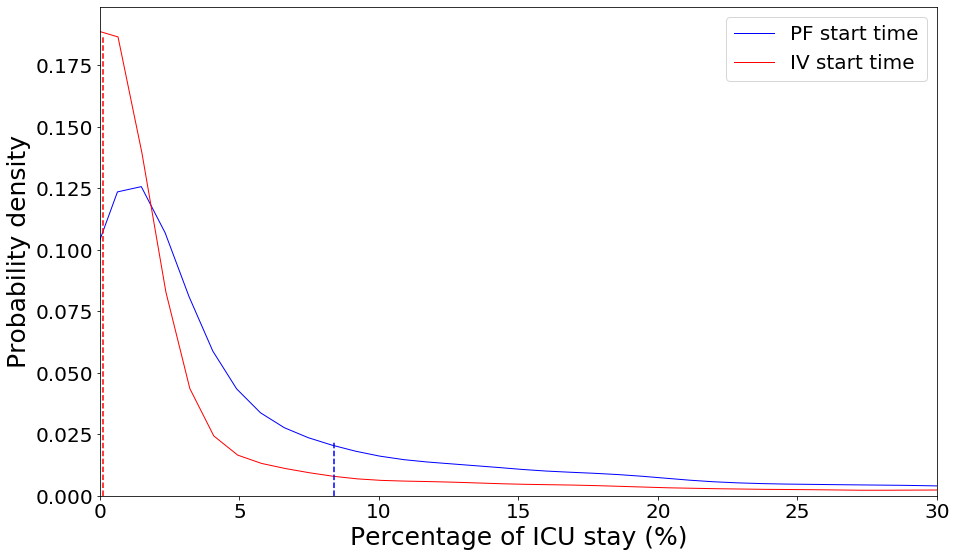

In [0]:
density_plot_any_2([both_p_f_1.chartoffset_norm,complete_start_series_IV],\
                 ['PF start time','IV start time'], ['b','r'], 'Percentage of ICU stay (%)')

In [0]:
both_p_f_1.chartoffset_norm.describe()

count    6458.000000
mean       18.326697
std        22.570558
min         0.000000
25%         1.856073
50%         8.353917
75%        26.783737
max        99.856867
Name: chartoffset_norm, dtype: float64

In [0]:
complete_start_series_IV.describe()

count    6725.000000
mean        5.765556
std        15.062797
min         0.000000
25%         0.000000
50%         0.038783
75%         1.962323
max        99.959163
dtype: float64

In [0]:
# for imputed:

In [0]:
# pick the first PF value and normalize using LOS:
impute_p_f_1 = impute_p_f.sort_values(by = ['patientunitstayid','time_diff'])
impute_p_f_1 = impute_p_f_1.groupby(['patientunitstayid']).first()
impute_p_f_1 = impute_p_f_1.reset_index()

In [0]:
impute_p_f_1

,patientunitstayid,pao2_time,fio2_time,fio2_value,time_diff,pf_ratio
0,534621,247,122,0.70,125,140.14
1,534967,787,7,0.35,780,256.29
2,536086,261,37,0.65,224,186.15
3,536299,81,28,0.60,53,126.67
4,536390,337,98,1.00,239,158.00
...,...,...,...,...,...,...
2633,3352797,5693,1193,0.50,4500,130.00
2634,3352878,2993,2591,0.40,402,212.50
2635,3352979,669,346,0.28,323,1000.00
2636,3353116,7615,6584,0.40,1031,327.50


In [0]:

def normalize_value_1(row, dictt):
  if int(row['patientunitstayid']) in dictt.keys():
    admit_offset = dictt[int(row['patientunitstayid'])]['ICU Admit'][0]
    discharge_offset = dictt[int(row['patientunitstayid'])]['ICU Discharge'][0]
    LOS_i = discharge_offset - admit_offset
    if LOS_i>=12:
      if (row['time_diff']/60.0)<LOS_i:
        return ((row['time_diff']/60.0)/LOS_i)*100
  return np.nan

In [0]:
impute_p_f_1['chartoffset_norm'] = impute_p_f_1.apply(normalize_value_1, dictt = first_icuid_dict, axis=1)

In [0]:
impute_p_f_1

,patientunitstayid,pao2_time,fio2_time,fio2_value,time_diff,pf_ratio,chartoffset_norm
0,534621,247,122,0.70,125,140.14,8.934954
1,534967,787,7,0.35,780,256.29,24.848678
2,536086,261,37,0.65,224,186.15,1.151730
3,536299,81,28,0.60,53,126.67,2.869518
4,536390,337,98,1.00,239,158.00,2.228854
...,...,...,...,...,...,...,...
2633,3352797,5693,1193,0.50,4500,130.00,50.669970
2634,3352878,2993,2591,0.40,402,212.50,7.403315
2635,3352979,669,346,0.28,323,1000.00,7.438968
2636,3353116,7615,6584,0.40,1031,327.50,11.547939


In [0]:
def density_plot_any_2(cols, locations, colors, xlab):
    
    loc_col = zip(locations,colors)
    j = 0

    # Iterate through the locations
    for i in loc_col:
        #subset = df_plot[df_plot['outcome']==i[0]]
    # Draw the density plot
        sns.distplot(cols[j], hist=False, kde=True, \
                 bins=50, color = i[1], \
                 hist_kws={'edgecolor':'black'},\
                 kde_kws={'linewidth': 1,"bw":1.5}, label = i[0], norm_hist=True)
        j+=1
    # Plot formatting
    plt.legend(prop={'size': 20})
    plt.gcf().set_size_inches(15, 9)
    #plt.title('Density Plot for ...', fontsize=20)
    plt.xlabel(xlab, fontsize=25)
    plt.ylabel('Probability density', fontsize=25)
    plt.xlim([0,30])
    plt.axvline(x=0.1, color='red', ymin=0, ymax=0.94, linestyle = '--')
    plt.axvline(x=6.7, color='blue', ymin=0, ymax=0.2, linestyle = '--')
    #plt.axvline(x=1.8, color='blue', ymin=0, ymax=0.92 , linestyle = '--')
    #plt.rcParams['xtick.labelsize']=8
    #plt.rcParams['ytick.labelsize']=8
    plt.rc('xtick',labelsize=20)
    plt.rc('ytick',labelsize=20)
    plt.show()

/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric/kde.py:447: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric/kde.py:447: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.


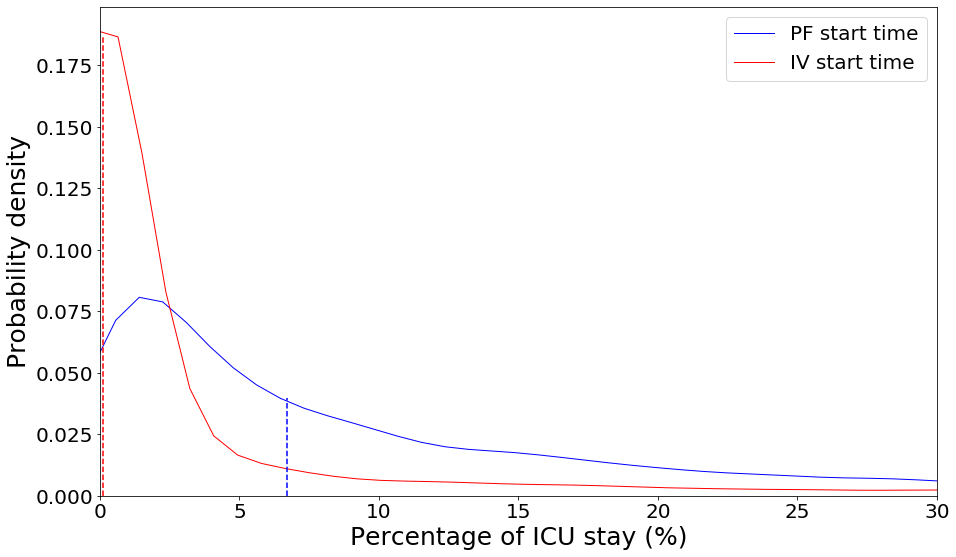

In [0]:
density_plot_any_2([impute_p_f_1.chartoffset_norm,complete_start_series_IV],\
                 ['PF start time','IV start time'], ['b','r'], 'Percentage of ICU stay (%)')

In [0]:
impute_p_f_1.chartoffset_norm.describe()

count    2454.000000
mean       13.650150
std        17.740820
min         0.006109
25%         2.081298
50%         6.565681
75%        17.521547
max        98.077501
Name: chartoffset_norm, dtype: float64

## Filter our first ICU stay dict by LOS and IV value availability 

In [0]:
first_icuid_dict

{534589: {'ICU Admit': [0.0],
  'ICU Discharge': [7.1],
  'IV': [],
  'NIV': [],
  'O2': []},
 534605: {'ICU Admit': [0.0],
  'ICU Discharge': [46.75],
  'IV': [(-0.083, 14.633)],
  'NIV': [],
  'O2': [(14.633, nan)]},
 534621: {'ICU Admit': [0.0],
  'ICU Discharge': [23.316666666666666],
  'IV': [(-0.317, 4.35)],
  'NIV': [],
  'O2': [(4.35, nan)]},
 534637: {'ICU Admit': [0.0],
  'ICU Discharge': [18.916666666666668],
  'IV': [],
  'NIV': [],
  'O2': []},
 534930: {'ICU Admit': [0.0],
  'ICU Discharge': [45.35],
  'IV': [],
  'NIV': [(0.5, nan)],
  'O2': [(0.0, nan)]},
 534942: {'ICU Admit': [0.0],
  'ICU Discharge': [26.083333333333332],
  'IV': [],
  'NIV': [],
  'O2': [(-0.667, nan)]},
 534967: {'ICU Admit': [0.0],
  'ICU Discharge': [52.31666666666667],
  'IV': [],
  'NIV': [(0.45, nan)],
  'O2': []},
 534981: {'ICU Admit': [0.0],
  'ICU Discharge': [26.633333333333333],
  'IV': [],
  'NIV': [],
  'O2': []},
 535141: {'ICU Admit': [0.0],
  'ICU Discharge': [3.4833333333333334],
 

In [0]:
# Are there any duplicate ICUids in the dict?

In [0]:
sum(pd.Series(list(first_icuid_dict.keys())).duplicated())

0

In [0]:
# filter:
# ICU LOS should be >= 24
# IV list should have some content => that indicates MV pt. 
key_list = []
for i in first_icuid_dict.keys():
  admit_offset = first_icuid_dict[i]['ICU Admit'][0]
  discharge_offset = first_icuid_dict[i]['ICU Discharge'][0]
  LOS_i = discharge_offset - admit_offset

  if (LOS_i>=24):   # consider patients with LOS>24hrs
    i_list = first_icuid_dict[i]['IV']
    for j in i_list:
      if (~np.isnan(j[0])) | (~np.isnan(j[1])): # one side time has to be there
          key_list.append(i)

# extract those pts from the dict
icu_24_IV_dict = first_icuid_dict.copy()
[icu_24_IV_dict.pop(x) for x in list(set(first_icuid_dict.keys()).difference(set(key_list)))] # pop out all the other keys


[{'ICU Admit': [0.0],
  'ICU Discharge': [16.966666666666665],
  'IV': [(-0.117, nan)],
  'NIV': [],
  'O2': []},
 {'ICU Admit': [0.0],
  'ICU Discharge': [378.0833333333333],
  'IV': [],
  'NIV': [],
  'O2': []},
 {'ICU Admit': [0.0],
  'ICU Discharge': [14.316666666666666],
  'IV': [],
  'NIV': [],
  'O2': [(-3.133, nan)]},
 {'ICU Admit': [0.0],
  'ICU Discharge': [76.18333333333334],
  'IV': [],
  'NIV': [],
  'O2': [(0.167, 33.4)]},
 {'ICU Admit': [0.0],
  'ICU Discharge': [26.2],
  'IV': [],
  'NIV': [],
  'O2': [(0.033, 23.767)]},
 {'ICU Admit': [0.0],
  'ICU Discharge': [41.9],
  'IV': [],
  'NIV': [],
  'O2': [(0.017, nan)]},
 {'ICU Admit': [0.0],
  'ICU Discharge': [30.633333333333333],
  'IV': [],
  'NIV': [(9.05, nan)],
  'O2': [(0.8, nan)]},
 {'ICU Admit': [0.0],
  'ICU Discharge': [25.133333333333333],
  'IV': [],
  'NIV': [],
  'O2': []},
 {'ICU Admit': [0.0],
  'ICU Discharge': [33.88333333333333],
  'IV': [],
  'NIV': [],
  'O2': []},
 {'ICU Admit': [0.0],
  'ICU Discha

In [0]:
len(icu_24_IV_dict.keys())

6077

In [0]:
icu_24_IV_dict

{534605: {'ICU Admit': [0.0],
  'ICU Discharge': [46.75],
  'IV': [(-0.083, 14.633)],
  'NIV': [],
  'O2': [(14.633, nan)]},
 535839: {'ICU Admit': [0.0],
  'ICU Discharge': [363.71666666666664],
  'IV': [(-0.2, 268.05)],
  'NIV': [],
  'O2': []},
 536086: {'ICU Admit': [0.0],
  'ICU Discharge': [324.15],
  'IV': [(0.233, 82.067)],
  'NIV': [(82.067, 95.733)],
  'O2': [(95.733, nan)]},
 536299: {'ICU Admit': [0.0],
  'ICU Discharge': [30.783333333333335],
  'IV': [(-0.433, 3.767)],
  'NIV': [],
  'O2': [(-206.45, -174.583), (-112.0, -73.183), (3.767, nan)]},
 536356: {'ICU Admit': [0.0],
  'ICU Discharge': [84.48333333333333],
  'IV': [(66.1, 69.6)],
  'NIV': [],
  'O2': [(-0.65, 21.35), (69.6, nan)]},
 536390: {'ICU Admit': [0.0],
  'ICU Discharge': [178.71666666666667],
  'IV': [(1.033, 113.867)],
  'NIV': [(-0.217, 1.033), (113.867, 127.783)],
  'O2': [(-1.717, nan), (127.783, nan)]},
 536645: {'ICU Admit': [0.0],
  'ICU Discharge': [70.8],
  'IV': [(-0.1, 51.15)],
  'NIV': [],
  'O

In [0]:
# Were there any first ICU eps had start time missing? 0
cn = 0
for i in icu_24_IV_dict.keys():
  first_ep = icu_24_IV_dict[i]['IV'][0]
  if np.isnan(first_ep[0]):
    cn += 1
print(cn)

0


In [0]:
# Were there any first ICU eps had end time missing? 2787
cn = 0
for i in icu_24_IV_dict.keys():
  first_ep = icu_24_IV_dict[i]['IV'][0]
  if np.isnan(first_ep[1]):
    cn += 1
print(cn)

2787


In [0]:
first24hr_pf = pd.DataFrame()
for icu_id in icu_24_IV_dict.keys():
  MV_list = first_icuid_dict[icu_id]['IV']
  first_MV_start = MV_list[0][0]
  MV_plus_24hr =   first_MV_start + 24.0 # watch period end time from the first MV

  for MV_i in MV_list[::-1]:  
      if (~np.isnan(first_MV_start)): # check if the start of fist MV is nan
        found_pf = 0 # set to 1 once we found a valid pf value

        # read all PF_both values first
        pf_both_df = both_p_f[both_p_f.patientunitstayid==icu_id].sort_values(by='chartoffset', ascending=False).reset_index(drop=True)
        pf_both_df['chartoffset'] = pf_both_df['chartoffset']/60.0

        for i,row in pf_both_df.iterrows():
          if ((row['chartoffset']) <= min(MV_plus_24hr, MV_i[1])) & ((row['chartoffset']) >= MV_i[0]):
            temp = pd.DataFrame({'patientunitstayid': [icu_id],'chartoffset_hrs':[row['chartoffset']], 'pf_ratio': [row['pf_ratio']]})
            first24hr_pf = pd.concat([first24hr_pf, temp])
            found_pf = 1
            break 

        # if pf_both not found, get pf from imputed table if availabel
        if found_pf==0:
          pf_impute_df = impute_p_f[impute_p_f.patientunitstayid==icu_id].sort_values(by='time_diff', ascending=False).reset_index(drop=True)
          pf_impute_df['time_diff'] = pf_impute_df['time_diff']/60.0
          for i,row in pf_impute_df.iterrows():
            if ((row['time_diff']) <= min(MV_plus_24hr, MV_i[1])) & (row['time_diff'] >= MV_i[0]):
              temp = pd.DataFrame({'patientunitstayid': [icu_id],'chartoffset_hrs':[row['time_diff']], 'pf_ratio': [row['pf_ratio']]})
              first24hr_pf = pd.concat([first24hr_pf, temp])
              break 

        if found_pf==1: 
           break  

In [0]:
np.nan + 24.0

nan

In [0]:
first24hr_pf.patientunitstayid.nunique()

4804

In [0]:
def hypo_outcome(x):
  if x<=100.0:
    return 'severe'
  elif (x>100) & (x<=200):
    return 'moderate'
  elif (x>200) & (x<=300):
    return 'mild'
  else:
    return 'no hypoxemia'

In [0]:
first24hr_pf['hyp_cat'] = first24hr_pf.pf_ratio.apply(hypo_outcome)

In [0]:
first24hr_pf

,patientunitstayid,chartoffset_hrs,pf_ratio,hyp_cat
0,534605,13.500000,235.000000,mild
0,535839,23.100000,74.000000,severe
0,536086,3.733333,186.150000,moderate
0,536299,0.883333,126.670000,moderate
0,536390,15.616667,238.750000,mild
...,...,...,...,...
0,3353144,15.133333,236.666667,mild
0,3353213,0.733333,240.000000,mild
0,3353216,20.133333,222.500000,mild
0,3353226,15.200000,306.000000,no hypoxemia


In [0]:
# example 1:
print(icu_24_IV_dict[534605])
print(first24hr_pf[first24hr_pf.patientunitstayid==534605])


{'ICU Admit': [0.0], 'O2': [(14.633, nan)], 'NIV': [], 'IV': [(-0.083, 14.633)], 'ICU Discharge': [46.75]}
   patientunitstayid  chartoffset_hrs  pf_ratio hyp_cat
0             534605             13.5     235.0    mild


In [0]:
both_p_f[both_p_f.patientunitstayid==534605].sort_values(by='chartoffset')

,patientunitstayid,chartoffset,fio2,pao2,pf_ratio
1227329,534605,3,1.0,283.0,283.000000
1302358,534605,189,0.6,103.0,171.666667
1361277,534605,810,0.4,94.0,235.000000


In [0]:
impute_p_f[impute_p_f.patientunitstayid==534605].sort_values(by='time_diff')

,patientunitstayid,pao2_time,fio2_time,fio2_value,time_diff,pf_ratio


In [0]:
# example 2:
print(icu_24_IV_dict[794133])
print(first24hr_pf[first24hr_pf.patientunitstayid==794133])

{'ICU Admit': [0.0], 'O2': [], 'NIV': [(230.5, 250.333), (253.833, 345.583)], 'IV': [(-0.25, 230.5), (250.333, 253.833), (345.583, 523.833)], 'ICU Discharge': [532.1333333333333]}
   patientunitstayid  chartoffset_hrs  pf_ratio hyp_cat
0             794133        21.983333     240.0    mild


In [0]:
both_p_f[both_p_f.patientunitstayid==794133].sort_values(by='chartoffset')

,patientunitstayid,chartoffset,fio2,pao2,pf_ratio
1185550,794133,2160,0.5,116.0,232.000000
1185551,794133,2823,0.5,160.0,320.000000
1366578,794133,3658,0.4,74.2,185.500000
1366579,794133,4970,0.4,98.6,246.500000
1366580,794133,6401,0.4,115.0,287.500000
1366581,794133,7955,0.4,105.0,262.500000
1366582,794133,9380,0.4,135.0,337.500000
1366583,794133,10720,0.4,128.0,320.000000
1366584,794133,11328,0.4,103.0,257.500000
1366585,794133,12207,0.4,85.8,214.500000


In [0]:
impute_p_f[impute_p_f.patientunitstayid==794133].sort_values(by='time_diff')

,patientunitstayid,pao2_time,fio2_time,fio2_value,time_diff,pf_ratio
11103,794133,55,14,0.7,41,93.86
11104,794133,650,14,0.7,636,191.43
11106,794133,23620,22301,0.5,1319,240.00
11105,794133,13925,12207,0.4,1718,212.75
11107,794133,25366,22301,0.5,3065,304.00
11108,794133,26570,22301,0.5,4269,286.00


Text(0, 0.5, '')

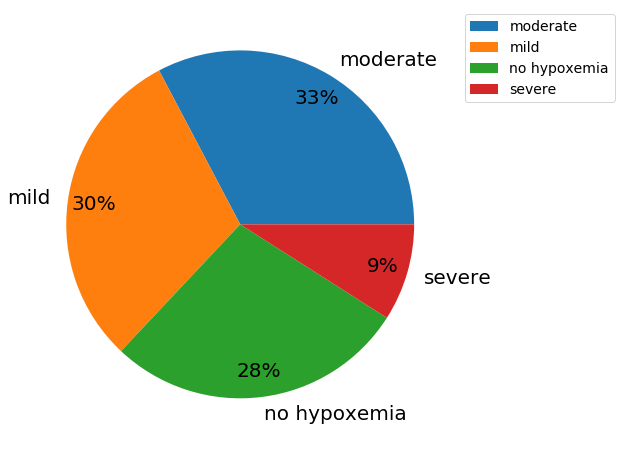

In [0]:
# plot the hypoxemia level distribution
pl = first24hr_pf.hyp_cat.value_counts().plot.pie(y='ACCOUNT_NBR_dist',\
                                                     figsize=(8, 8), autopct='%1.0f%%',\
                                                     pctdistance=0.85, labeldistance=1.1, textprops={'fontsize': 20})
pl.legend(prop={'size':14}, bbox_to_anchor=(1.0, 1.0))
pl.set_ylabel('')


In [0]:
first24hr_pf.hyp_cat.value_counts().to_frame()

,hyp_cat
moderate,1573
mild,1455
no hypoxemia,1345
severe,434


In [0]:
first24hr_pf.to_csv('pf-ratio_endof_firstMV_24hrs.csv')
#files.download('pf-ratio_endof_firstMV_24hrs.csv')

In [0]:
# Among the MV patients (i.e., IV available), how many of them do not have PF within first 24hrs?
len(icu_24_IV_dict.keys())- first24hr_pf.patientunitstayid.nunique()


1273

In [0]:
# What is the distribution of time gap between the final PF time point and 24h margin?
first24hr_pf_analyse = first24hr_pf.copy()

In [0]:
# compute time gap:
first24hr_pf_analyse['time gap between PF to MV24h'] = first24hr_pf_analyse.apply(lambda row: round(first_icuid_dict[row['patientunitstayid']]['IV'][0][0]+24.0 - row['chartoffset_hrs'],3) ,axis=1)

In [0]:
first24hr_pf_analyse.head()

,patientunitstayid,chartoffset_hrs,pf_ratio,hyp_cat,time gap between PF to MV24h
0,534605,13.500000,235.00,mild,10.417
0,535839,23.100000,74.00,severe,0.700
0,536086,3.733333,186.15,moderate,20.500
0,536299,0.883333,126.67,moderate,22.684
0,536390,15.616667,238.75,mild,9.416


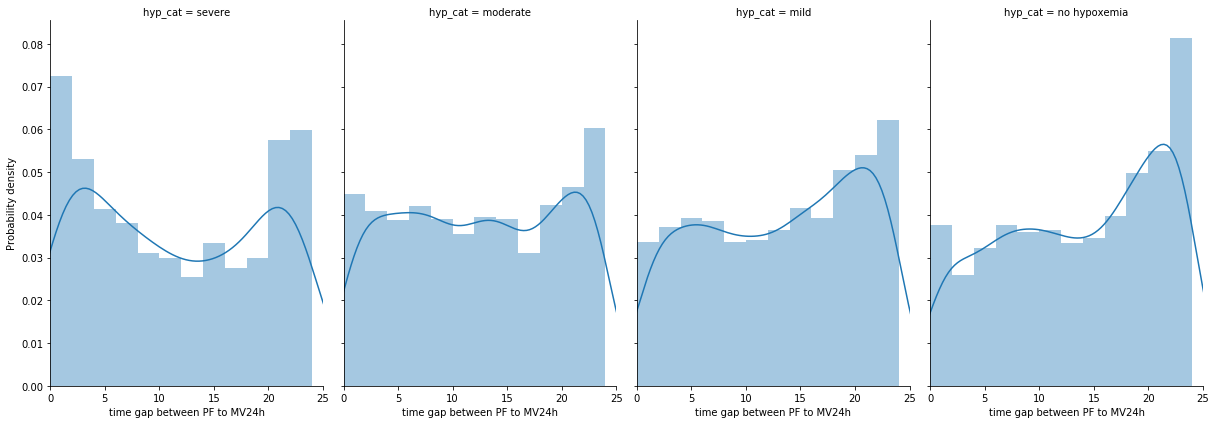

In [0]:

g = sns.FacetGrid(first24hr_pf_analyse, col="hyp_cat", height=6, aspect=.7, xlim={0,25}, col_order=["severe", "moderate","mild","no hypoxemia"])
bins = np.arange(0, 25, 2)
g = g.map(sns.distplot, "time gap between PF to MV24h", bins=bins)
g.set_ylabels("Probability density")


## Question: Do we have enough ICU stays with PF values around that first_MV_start time?

In [0]:
# Let's consider within 3hrs after MV start:
first3hr_pf = pd.DataFrame()
for icu_id in icu_24_IV_dict.keys():
  MV_list = first_icuid_dict[icu_id]['IV']
  first_MV_start = MV_list[0][0]
  MV_plus_3hr =   first_MV_start + 3.0 # watch period end time from the first MV

  for MV_i in MV_list[::-1]:  
      if (~np.isnan(first_MV_start)): # check if the start of fist MV is nan
        found_pf = 0 # set to 1 once we found a valid pf value

        # read all PF_both values first
        pf_both_df = both_p_f[both_p_f.patientunitstayid==icu_id].sort_values(by='chartoffset', ascending=False).reset_index(drop=True)
        pf_both_df['chartoffset'] = pf_both_df['chartoffset']/60.0

        for i,row in pf_both_df.iterrows():
          if ((row['chartoffset']) <= min(MV_plus_3hr, MV_i[1])) & ((row['chartoffset']) >= MV_i[0]):
            temp = pd.DataFrame({'patientunitstayid': [icu_id],'chartoffset_hrs':[row['chartoffset']], 'pf_ratio': [row['pf_ratio']]})
            first3hr_pf = pd.concat([first3hr_pf, temp])
            found_pf = 1
            break 

        # if pf_both not found, get pf from imputed table if availabel
        if found_pf==0:
          pf_impute_df = impute_p_f[impute_p_f.patientunitstayid==icu_id].sort_values(by='time_diff', ascending=False).reset_index(drop=True)
          pf_impute_df['time_diff'] = pf_impute_df['time_diff']/60.0
          for i,row in pf_impute_df.iterrows():
            if ((row['time_diff']) <= min(MV_plus_3hr, MV_i[1])) & (row['time_diff'] >= MV_i[0]):
              temp = pd.DataFrame({'patientunitstayid': [icu_id],'chartoffset_hrs':[row['time_diff']], 'pf_ratio': [row['pf_ratio']]})
              first3hr_pf = pd.concat([first3hr_pf, temp])
              break 

        if found_pf==1: 
           break 

In [0]:
first3hr_pf.patientunitstayid.nunique()

3091

In [0]:
first3hr_pf['hyp_cat'] = first3hr_pf.pf_ratio.apply(hypo_outcome)

Text(0, 0.5, '')

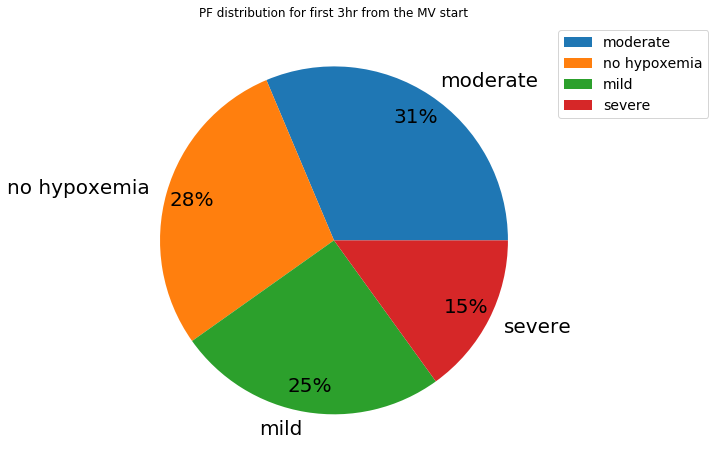

In [0]:
# plot the hypoxemia level distribution for first 3hr from MV start
pl = first3hr_pf.hyp_cat.value_counts().plot.pie(y='ACCOUNT_NBR_dist',\
                                                     figsize=(8, 8), autopct='%1.0f%%',\
                                                     pctdistance=0.85, labeldistance=1.1, textprops={'fontsize': 20}, title='PF distribution for first 3hr from the MV start')
pl.legend(prop={'size':14}, bbox_to_anchor=(1.0, 1.0))
pl.set_ylabel('')